# Small n evaluations: what to do with a p-value of .23
What do you do when you run an evaluation and your estimate of treatment effect is large but the p-value is only 0.23? You might reasonably conclude that 0.23 is better than a p-value of 0.5, but then again it is quite a bit larger than the typically used thresholds of 0.05 and 0.1. 

Of course, what we, and the client, really want is not a p-value but a probability.  In this case, let's suppose that there is another intervention that costs about the same and which we think has an effect of $\delta$.  In that case, what we really want to know is the probabiltiy that the intervention we are evaluating has an effect greater than $\delta$.  


## Input some fake data
Let's see how to do this for a simple example. First, let's input some fake data for a binary treatment and a binary outcome. 

In [2]:
# Create two vectors of fake data: one for a binary outcome and one for a binary treatment
import numpy as np
outcome = np.array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0])
treat_status = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

## Run a logit on the fake data
Next, let's run a standard logit on this data. When we run the logit, the estimate of the treatment effect is reasonable large but the p-value is only 0.23.  (Note that the following code is equivalent to running "logit outcome treat_status" in Stata.)

In [11]:
import statsmodels.api as sm
X = sm.add_constant(treat_status)
model = sm.GLM(outcome, X, family = sm.families.Binomial())
print(model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   70
Model:                            GLM   Df Residuals:                       68
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -45.951
Date:                Sun, 31 Jul 2016   Deviance:                       91.902
Time:                        10:34:20   Pearson chi2:                     70.0
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1335      0.366      0.365      0.715        -0.584     0.851
x1             0.5974      0.498      1.200      0.2

## Fit a Bayesian logit
The code below fits a Bayesian logit model to this data.  The key lines of code to pay attention to are 13 and 14. These lines specify the "prior" for the model parameters -- or our ex-ante beliefs on what the parameters should be.  In this case, my prior is that the intercept for the logit model (alpha) is distributed normally with mean 0 and standard deviation 10 and the slope for the logit model (beta) is also distributed normally with mean 0 and standard deviation 10.  In other words, ex-ante, I think that there is a 50/50 chance that the intervention has a positive versus a negative effect.  

In [7]:
import pystan
stan_code = '''
data {
    int<lower=0> N;  // number of observations
    int<lower=0,upper=1> y[N];  // outcome data
    vector[N] treat;  // variable indicating treatment arm for each observation
}
parameters {
    real alpha;
    real beta;
}
model {
    alpha ~ normal(0,10);  // our prior for alpha
    beta ~ normal(0,10); // our prior for beta
    y ~ bernoulli_logit(alpha + beta*treat);
}    
generated quantities {
    real effect;
    effect <- inv_logit(alpha+beta)-inv_logit(alpha);
}

'''
stan_data = {'N': len(outcome),
        'y': outcome,
        'treat': treat_status }
fit = pystan.stan(model_code=stan_code, data=stan_data, iter=1000, chains=4)

/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pic

# Analyze the results
Now that we have fitted the model, we want to use the results to estimate the probability that the effect of the intervention is greater than $\delta$.  The code above spits out a vector of values for "effect size." These values are approximate draws from the "posterior" for the effect size.  In other words, the vector contains a bunch of values drawn from the distribution of the effect size where the distribution is calculated using the model above. 

Let's first extract the vector for the posterior values and graph the values using a histogram. 

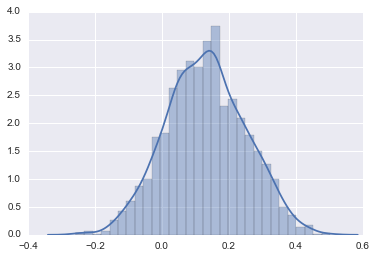

In [12]:
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

effect_sim = fit.extract()['effect']
sns.distplot(effect_sim)

Next, let's calculate the probability that the effect is greater than $\delta$.  For this example, let's assume $\delta$ is equal to .05, or, in other words, the other intervention we are comparing our intervention to causes a 5 percentage point increase in the probability of the outcome being a success. 

In [13]:
# calculate the probability that effect size is greater than 0
(effect_sim >0.05).sum()/len(effect_sim)

0.74199999999999999

## Takeaway
According to our model, the probability that the effect of the new intervention is greater than the intervention that we are comparing it to is 74%! Despite the large p-value for our initial analysis, the more thorough Bayesian shows that our message to the client should be clear: you should definitely take up this intervention.  

I should add one last cavet. In this example, a relatively large p-value ended up translating into a relatively large probability that the intervention is effective.  Please note that this is not always going to be the case!